# Assignment 1: Deep Learning Basics

Welcome to the first assignment of CS163 Computer Vision course!

First of all, please type your information below.

In [ ]:
#@title Your Info { display-mode: "form" }

Name = 'Maria Campo Martins'  #@param {type:"string"}
UID = ' 305982278'  #@param {type:"string"}

## Goals
In the first assignment, you will learn:
* How to use Google Colab
* How to implement a PyTorch data loader to load and preprocess the MiniPlaces dataset.
* How to implement a linear/logistic/softmax regression classifier
* How to build and train a fully-connected neural network from scratch and using built-in PyTorch modules.


Free free to raise issues in the Piazza forum if you find any bugs or have any questions about the assignment.

Please do not directly copy code from other sources and use any Code AI to finish the assignment.

You could either complete the assignment using a GPU or CPU runtime. As the computation is not heavy for this assignment, there will not be much difference between GPU and CPU. Update: You can apply for Colab Pro for free using your university email!

This assignment is due on **Sunday, Oct 19**. Good luck with your work!

❗**Once you have finished all the questions, it will still take approximately *60 minutes* to re-run the entire notebook in order to prepare the submission version. Make sure to allocate enough time for this task and start early.**

## Getting Started


### Overview

In this assignment, you will be working with the [MiniPlaces dataset](https://github.com/CSAILVision/miniplaces), a small-scale version of the [Places2 dataset](http://places2.csail.mit.edu/), which is a large-scale dataset of scene images (10+ million images) with a wide variety of real-world environments (400+ unique scene categories). The MiniPlaces dataset is a subset of the [Places2 dataset](http://places2.csail.mit.edu/) led by Prof. Bolei Zhou and contains 100,000 images for training, 10,000 images for validation, and 10,000 images for testing, each of which has been annotated with one of 100 different scene categories. These images are divided into three folders: train, val, and test.

The MiniPlaces dataset is a useful resource for developing and testing image classification models, particularly those that are designed to recognize different types of environments and scenes.

In this assignment, you will use PyTorch to load the MiniPlaces dataset and compare different image classification methods including linear/logistic/softmax regression classifier and a fully-connected neural network.

Throughout the course, we will be using [PyTorch](https://pytorch.org/) for building and training different neural networks. It would be highly beneficial to go through the PyTorch [tutorials](https://pytorch.org/tutorials/) and get familiar with its APIs.

---


## Q0: Data Preparation(0 pts)

Colab is a cloud-based service that allows users to write and run code in a Jupyter notebook-style enviroment. Colab provides users with temporary virtual machines to run their code on.

For file storage, Colab provides users with access to a variety of storage options, including temporary storage space and Google Drive storage.

1. Temporary storage space, also known as "local runtime storage," is a space on the virtual machine (VM) that is allocated to you when you open a Colab notebook. This space is temporary in the sense that it is wiped clean whenever you close the notebook or disconnect from the VM. However, it is much faster than Google Drive storage, since it is located on the same machine as the VM. This makes it ideal for storing and accessing large datasets or intermediate data that is being used frequently in your notebook.

2. Google Drive storage is a more permanent storage option that is accessed through your Google account. It is ***much much*** slower than temporary storage space, since it requires data to be transferred over the internet to and from the VM. However, it is useful for storing and sharing notebooks and data that you want to keep long-term, or for collaborating with other users.

As we are going to be working with a lot of images, and to make things run smoothly, we will be using Colab's temporary storage space to store our data. This means that every time you open up this notebook, we will need to **re-upload and process the dataset**. Don't worry though - this shouldn't take long, usually just a minute or less. Okay, let's get started!

In [1]:
# Import all the common packages, you can just rerun this cell if you restart the kernel and found some packages are missing
# It is also good for you to get familiar with these packages
import cv2 # defines functions for computer vision tasks
import matplotlib.pyplot as plt # defines functions for plotting
import numpy as np # defines functions for manipulating arrays
import os # defines operating system related functions
import random # defines functions for generating random numbers
import torch # defines functions for tensor computations
import torch.nn as nn # defines modules for building neural networks
import torch.nn.functional as F # defines functions for building neural networks
from PIL import Image  # defines the Python Imaging Library (Pillow) for image processing
from torchvision import transforms # defines functions for image transformations
from torch.utils.data import DataLoader, Dataset # defines functions for data loading and dataset handling
from tqdm import tqdm # defines functions for displaying progress bars

To begin, you will need to download the MiniPlaces Dataset (`MiniPlaces.zip`) from UCLA box **with the following link:**
https://ucla.box.com/s/ikd1jsad17no71bugzhw3nkrhkdq12x0

Downloading this dataset typically takes less than 15 seconds.
You will then need to upload the downloaded dataset to the temporary storage space illustrated below:

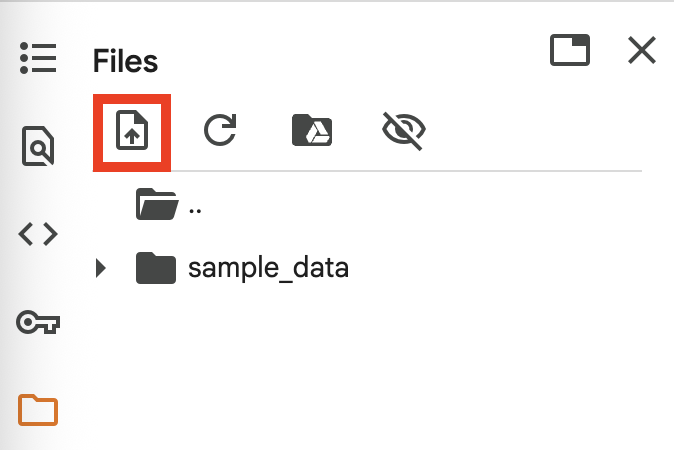

In the following code, we setup the root directory for our project, extract the dataset to the root directory, and download the label files.

In [2]:
# Let's make our assignment directory
CS163_path = './CS163'
os.makedirs(CS163_path, exist_ok=True)
# os.makedirs will create directories recursively, i.e., it will create the
# directories and any missing parent directories if they do not exist.

# Now, let's specify the assignment path we will be working with as the root.
root_dir = os.path.join(CS163_path, 'MiniPlaces')

!unzip -q MiniPlaces.zip -d ./CS163

Also, it is a good habit to setup the seed before running any experiment to ensure reproducibility.

In [3]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(0)

## Q1: PyTorch Dataset (20 pts)
In this part, you will implement a PyTorch dataset to load and preprocess the MiniPlaces dataset.


### Q1.1 Data Transform (7 pts)

In this sub-question, you will be loading a sample image from the MiniPlaces dataset and applying a data transformation to it using the `torchvision.transforms.Compose` function.

First, let's load a sample image from the `{root_dir}/images/train/a/abbey/00000001.jpg` file and print some properties about it:


Data type of my image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape of image: (128, 128, 3)
Channel mode: RGB
Value range of image: ((0, 255), (0, 255), (0, 255))


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

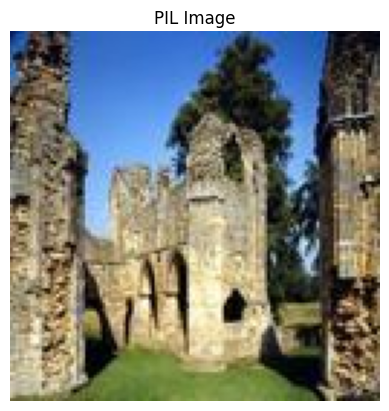

In [4]:
# Load sample image
image = Image.open(f'{root_dir}/images/train/a/abbey/00000001.jpg')
print(f'Data type of my image: {type(image)}')
print(f"Shape of image: {np.array(image).shape}")
print(f'Channel mode:', image.mode)
print(f"Value range of image: {image.getextrema()}")

plt.imshow(image)
plt.title('PIL Image')
plt.axis('off')

You should be aware of the following data properties:
* The loaded image is in the format of "channel-last", with the shape of (height, width, channels), instead of (channels, height, width).
* The channel mode is RGB, meaning the channels are ordered as red, green, and blue.
* The value range of the data is between 0 and 255, so the data type is most likely uint8.

Now let's try loading the same image using **opencv**.


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

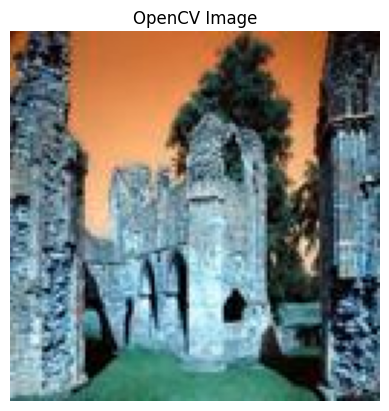

In [5]:
image_opencv = cv2.imread(f'{root_dir}/images/train/a/abbey/00000001.jpg')

# Display image using matplotlib
plt.imshow(image_opencv)
plt.title('OpenCV Image')
plt.axis('off')

It is important to keep in mind these subtle differences when loading images using **opencv** or **PIL**. Be mindful of these variations when working with image data.

In addition to the sample image, you can also experiment with loading other images from the dataset for further exploration.

---

All images in the MiniPlaces dataset have a shape of (128, 128), and have a `uint8` (0~255) data type.

Next, you should define a data transform function using [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html). Compose that resizes the image to 32x32, converts it to a tensor, and normalizes it using ImageNet statistics, i.e., `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]`, be familiar with those numbers and remember to **always** normalize the image before feeding it to the networks. Finally, flatten the image to a $32\times32\times3$-D vector.

In [6]:
# define the ImageNet statistics
image_net_mean = torch.Tensor([0.485, 0.456, 0.406])
image_net_std = torch.Tensor([0.229, 0.224, 0.225])

First, Let's take a look at the `transforms.ToTensor()`.

In [7]:
print('original image:',
      f'  type: {type(image)}',
      f'  shape: {np.array(image).shape}',
      f'  values: max={np.max(image)}, min={np.min(image)}',
      sep='\n')

_t_img = transforms.ToTensor()(image)
print('after ToTensor transformation:',
      f'  type: {type(_t_img)}',
      f'  shape: {_t_img.shape}',
      f'  values: max={_t_img.max()}, min={_t_img.min()}',
      sep='\n')

original image:
  type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
  shape: (128, 128, 3)
  values: max=255, min=0
after ToTensor transformation:
  type: <class 'torch.Tensor'>
  shape: torch.Size([3, 128, 128])
  values: max=1.0, min=0.0


Make sure you understand what `transforms.ToTensor()` does and complete the following data transform:

In [8]:
# Define data transformation
data_transform = transforms.Compose([
    ################# Your Implementations #####################################
    # TODO: Resize image to 32x32
    transforms.Resize((32, 32)),
    ################# End of your Implementations ##############################
    transforms.ToTensor(),

    ################# Your Implementations #####################################
    # TODO: Normalize image using ImageNet statistics
    #     : Flatten the image with torch.flatten
    transforms.Normalize(mean=image_net_mean, std=image_net_std),
    transforms.Lambda(lambda x: torch.flatten(x))
    ################# End of your Implementations ##############################
])

Let's see how `data_transform` works:

In [9]:
transformed_img = data_transform(image)
print('shape:', transformed_img.shape)
print('values:', transformed_img)

shape: torch.Size([3072])
values: tensor([-1.6898, -1.2959, -0.9020,  ..., -0.6541, -0.7413, -0.8110])


You should get results similar to the following if you're using the same image (`f'{root_dir}/images/train/a/abbey/00000001.jpg`):

```
shape: torch.Size([3072])
values: tensor([-1.6898, -1.2959, -0.9020,  ..., -0.6541, -0.7413, -0.8110])
```

After defining the data transform function, you can use it to transform the sample image and visualize the result. Here is an example.

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

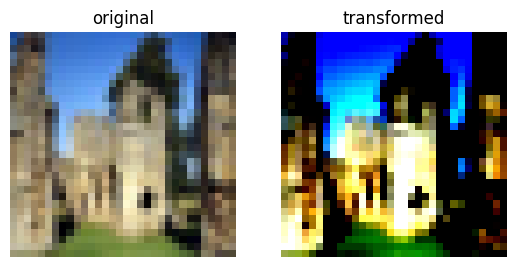

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(image.resize((32, 32)))
plt.title('original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(transformed_img.reshape(3, 32, 32).permute(1, 2, 0))
plt.title('transformed')
plt.axis('off')

You will find that the transformed image is significantly distorted in terms of color.

This is caused by the normalization step. Therefore, we need to undo this step to recover the original image.

To do this, let's write a `tensor_to_image` function that inverts the data transformation process. This function should take a tensor image as input and return a displayable image.

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

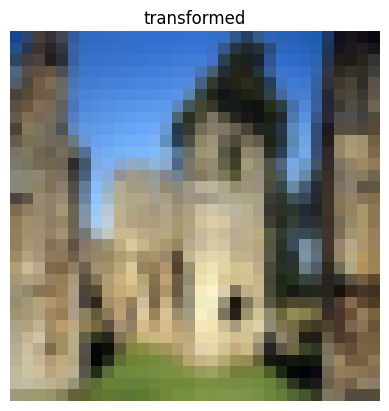

In [11]:
def tensor_to_image(image):
    """
    Convert a tensor image back to a displayable image.

    Args:
        image (torch.Tensor): Tensor image to convert.

    Returns:
        numpy.ndarray: Displayable image.
    """
    tensor_image = image.clone().detach()
    # TODO: transform the tensor_image into a numpy_image that is displayable by plt.
    ################# Your Implementations #####################################
    # Hints:  Reshape image vector to (3, 32, 32)
    #         Transpose tensor image to (32, 32, 3)
    #         Undo normalization
    #         Convert tensor image to numpy array
    ################# End of your Implementations ##############################
    tensor_image = tensor_image.view(3, 32, 32)
    for t, m, s in zip(tensor_image, image_net_mean, image_net_std):
      t.mul_(s).add_(m)
    numpy_image = tensor_image.permute(1, 2, 0)
    numpy_image = numpy_image.numpy()
    return numpy_image


# check your implemention
plt.imshow(tensor_to_image(transformed_img))
plt.title('transformed')
plt.axis('off')

### Q1.2 MiniPlaces Dataloader (7 pts)

You will implement a pytorch data loader for the MiniPlaces dataset, following the tutorial [here](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/57a471142057f27da635118e88a99bf6/data_tutorial.ipynb
).

Complete the following cell and debug it if necessary.

In [ ]:
class MiniPlaces(Dataset):

    def __init__(self, root_dir, split, transform=None, label_dict=None):
        """
        Initialize the MiniPlaces dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the MiniPlaces images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.filenames = []
        self.labels = []

        # Take a second to think why we need this line.
        # Hints: training set / validation set / test set.
        # Training and validation need labels: test set does not
        self.label_dict = label_dict if label_dict is not None else {}

        # You should
        #   1. Load the train/val/test text file based on the `split` argument and
        #     store the image filenames and labels.
        #   2. Extract the class names from the image filenames and store them in
        #     self.label_dict.
        #   3. Construct a label dict that maps integer labels to class names, if
        #     the current split is "train"
        ################# Your Implementations #####################################
        if split == 'train':
          with open("train.txt", "r") as f:
            for line in f:
              filename, label = line.strip().split()
              label = int(label)
              classname = filename.split('/')[2]
              label_dict[label] = classname
              self.filenames.append(filename)
              self.labels.append(label)
        elif split == 'val':
          with open("val.txt", "r") as f:
            for line in f:
              filename, label = line.strip().split()
              label = int(label)
              self.filenames.append(filename)
              self.labels.append(label)
        ################# End of your Implementations ##############################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #####################################
        # Return the number of images in the dataset

        ################# End of your Implementations ##############################
        return dataset_len

    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #####################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)

        ################# End of your Implementations ##############################
        return image, label

In [ ]:
seed_everything(0)
# Create MiniPlaces dataset object
miniplaces_train = MiniPlaces(root_dir,
                              split='train',
                              transform=data_transform)

# Check our implementation
print('len of trainining dataset:', len(miniplaces_train))
print('label_dict:', miniplaces_train.label_dict)
random_idxs = np.random.choice(len(miniplaces_train), 3)
print('Example filenames:',
      [miniplaces_train.filenames[i] for i in random_idxs])
print('Example class IDs:', [miniplaces_train.labels[i] for i in random_idxs])
print('Example class names:', [
    miniplaces_train.label_dict[miniplaces_train.labels[i]]
    for i in random_idxs
])
print()

miniplaces_val = MiniPlaces(root_dir, split='val', transform=data_transform)
print('val label_dict:', miniplaces_val.label_dict)

If you have successfully implemented the dataset, the above code should give you results like this:


```
len of trainining dataset: 100000
label_dict: {0: 'abbey', 1: 'airport_terminal', 2: 'amphitheater', 3: 'amusement_park', 4: 'aquarium', 5: 'aqueduct', 6: 'art_gallery', 7: 'assembly_line', 8: 'auditorium', 9: 'badlands', 10: 'shop', 11: 'ballroom', 12: 'bamboo_forest', 13: 'banquet_hall', 14: 'bar', 15: 'baseball_field', 16: 'bathroom', 17: 'beauty_salon', 18: 'bedroom', 19: 'boat_deck', 20: 'bookstore', 21: 'botanical_garden', 22: 'bowling_alley', 23: 'boxing_ring', 24: 'bridge', 25: 'bus_interior', 26: 'butchers_shop', 27: 'campsite', 28: 'candy_store', 29: 'canyon', 30: 'cemetery', 31: 'chalet', 32: 'outdoor', 33: 'classroom', 34: 'clothing_store', 35: 'coast', 36: 'cockpit', 37: 'coffee_shop', 38: 'conference_room', 39: 'construction_site', 40: 'corn_field', 41: 'corridor', 42: 'courtyard', 43: 'dam', 44: 'sand', 45: 'dining_room', 46: 'driveway', 47: 'fire_station', 48: 'food_court', 49: 'fountain', 50: 'gas_station', 51: 'golf_course', 52: 'harbor', 53: 'highway', 54: 'hospital_room', 55: 'hot_spring', 56: 'outdoor', 57: 'iceberg', 58: 'kindergarden_classroom', 59: 'kitchen', 60: 'laundromat', 61: 'lighthouse', 62: 'living_room', 63: 'lobby', 64: 'locker_room', 65: 'outdoor', 66: 'martial_arts_gym', 67: 'outdoor', 68: 'mountain', 69: 'indoor', 70: 'office', 71: 'palace', 72: 'parking_lot', 73: 'phone_booth', 74: 'playground', 75: 'racecourse', 76: 'railroad_track', 77: 'rainforest', 78: 'restaurant', 79: 'river', 80: 'rock_arch', 81: 'runway', 82: 'shed', 83: 'shower', 84: 'ski_slope', 85: 'skyscraper', 86: 'slum', 87: 'football', 88: 'indoor', 89: 'staircase', 90: 'platform', 91: 'supermarket', 92: 'swamp', 93: 'outdoor', 94: 'east_asia', 95: 'outdoor', 96: 'trench', 97: 'valley', 98: 'volcano', 99: 'yard'}
Example filenames: ['train/m/mountain/00000269.jpg', 'train/d/dam/00000568.jpg', 'train/c/courtyard/00000614.jpg']
Example class IDs: [68, 43, 42]
Example class names: ['mountain', 'dam', 'courtyard']

val label_dict: {}
```

----
Since validation and test annotation files do not have class information, we should pass the `label_dict` obtained from the training set to them.


In [ ]:
miniplaces_val = MiniPlaces(root_dir,
                            split='val',
                            transform=data_transform,
                            label_dict=miniplaces_train.label_dict)

print('val label_dict:', miniplaces_val.label_dict)

Now you should see the same `label_dict` as the tranining set.

---

Next, let's visualize the image in each category.

In [ ]:
figure = plt.figure(figsize=(24, 24))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(miniplaces_train), size=(1, )).item()
    img, label = miniplaces_train[sample_idx]
    class_name = miniplaces_train.label_dict[label]
    figure.add_subplot(rows, cols, i)
    plt.title(class_name)
    plt.axis("off")
    plt.imshow(tensor_to_image(img))
plt.show()

Finally, we define the pytorch `DataLoader` for loading images into batches of data, make sure you have followed the [tutorial](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/57a471142057f27da635118e88a99bf6/data_tutorial.ipynb
) and understand what is the use of `DataLoader`.

In [ ]:
# Define the batch size and number of workers
batch_size = 64
num_workers = 2

# Create DataLoader for training and validation sets
train_loader = DataLoader(miniplaces_train,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(miniplaces_val,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=False)

### Q1.3 Answer the following questions (6 pts):


a. In a few words, describe the differences between loading images using **PIL** and **opencv**. (2 pts)

(Double click to edit)

Your answer:

---

b. In 1-2 sentences, explain why do we need to normalize the images before training. (2 pts)

(Double click to edit)

Your answer:

---

c. In 1-2 sentences, explain the use of PyTorch ```DataLoader``` and its different from the PyTorch ```Dataset```. (2 pts)



(Double click to edit)

Your answer:

---

## Q2: Regression (40 pts)

For this question, you will be implementing and evaluating the performance of linear, logistic and softmax regression classifier on the TinyPlaces dataset.

Recall some details:
 1. Linear Regression models the relationship between an input and an output by fitting a linear function to the data. In this assignemnt, we will use the Mean Square Error (MSE) loss function to minimize the weights and biases of the linear function.
 2. Logistic Regression is commonly used for binary classification tasks. It is an extension of linear regression that adds a logistic function to the linear output. We will use the Binary Cross Entropy Loss to optimize the logistic regression model.
 3. Softmax regression is usually used for multiclass classification tasks. It is an extension of linear regression that adds a softmax function to the linear output and uses the Cross Entropy loss to optimize the model.



The goal of this exercise is to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in PyTorch.

❗
You may not use any functions from `torch.nn` or `torch.nn.functional` in your implementation, except for the `torch.nn.functional.one_hot` used in Q2.2 and Q2.3.


The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

You may not use any functions from torch.nn or torch.nn.functional.

 We will run the codes on GPU. Go to:
Runtime->Change Runtime Type->Hardware Accelerator->GPU

In [ ]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

In [ ]:
# This line of code gives you the information about GPU
! nvidia-smi

### Q2.1 Linear Regression (10 pts)

In this part of the question, you will implement linear regression for image classification on the TinyPlaces dataset. Your goal is to predict the category of an image based on its pixel values.

To do this, you will need to complete the following steps:

1. Initialize the weights and biases of the linear regression model and implement the linear function and the predict function in the LinearRegression class. If the prediction score is greater than 0.5, we consider the image to be of the outdoor category. Otherwise, we consider it to be of the indoor category.

2. Use the fit function in the LinearRegression class to fit the linear regression model to the training data using gradient descent. You will need to set the learning rate and the number of epochs for the gradient descent algorithm.

3. Evaluate the performance of the linear regression model on the training and validation datasets using the evaluate function in the LinearRegression class. This function should calculate the accuracy of the model on the dataset.

---

We will implement linear regression step by step.

Remember that for linear regression:

$$y = WX+b$$

In our case, $X$ is the flattened image vector with a dimenstion of $32\times32\times3=3072$. Thus, the weight $W$ should be compatible with the dim of $X$.

We use the linear function to directly predict the label ranging from 0-99.



---
Below is the class you need to implement. Don't be scared. Each code block requires a very few lines of implementation.

You do not need to finish all the class functions at once. Instead, you should finish them one by one and try to debug them.

In [ ]:
class LinearRegression(object):

    def __init__(self, input_size, output_size):
        """
          Initialize the weights and biases using zeros

          Parameters:
              input_size (int): The input size (dimension of feature vectors)
              output_size (int): The output size (dimension of output logits)

          Returns:
              None.
        """
        # Initialize and set the device for the weights and biases using zeros
        # Remember to set requires_grad=True
        ################# Your Implementations ################################

        ################# End of your Implementations ##########################

    def linear(self, x):
        # Implement the linear function using y = Wx + b
        ################# Your Implementations ################################

        ################# End of your Implementations ##########################
        return output

    def forward(self, x):
        # To make the output shape compact.
        return self.linear(x).squeeze()

    def get_loss(self, preds, targets):
        # Calculate the mean squared error between the predicted labels and the ground-truth labels
        ################# Your Implementations ################################

        ################# End of your Implementations ##########################
        return loss

    def fit(self, train_loader, val_loader, lr, epochs=5):
        # Fit the linear regression model to the training data using gradient descent
        # lr is the learning rate, epochs is the number of epochs

        # To store validation accuracy
        val_accs = []
        train_losses = []
        for epoch in range(epochs):
            # Create a progress bar using tqdm
            pbar = tqdm(total=len(train_loader),
                        desc=f'Epoch {epoch + 1}/{epochs}',
                        position=0,
                        leave=True)
            epoch_loss = 0
            iter = 0
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                # TODO: finish the training steps:
                ################# Your Implementations ################################
                # 1. Calculate the loss
                # 2. Backpropagate the loss to compute the gradients

                with torch.no_grad():
                    # 3. Update the weights and biases using gradient descent ()
                    # 4. Reset the gradients by calling grad.zero_()

                ################# End of your Implementations ##########################
                pbar.set_postfix(loss=loss.item(), lr=lr)
                pbar.update()
                epoch_loss += loss.item()
                iter += 1
            # Calculate the validation accuracy
            val_acc = self.evaluate(val_loader)
            val_accs.append(val_acc)
            # Calculate the average training loss
            epoch_loss = epoch_loss / iter
            train_losses.append(epoch_loss)
            # Update the progress bar with the validation accuracy and training loss
            pbar.set_description(
                f'val_acc: {val_acc:.3f}, train_loss: {epoch_loss:.3f}')
        return val_accs, train_losses

    def evaluate(self, data_loader):
        # Evaluate the performance of the linear regression model on the dataset
        count = 0
        correct = 0
        pbar = tqdm(range(len(data_loader)),
                    desc='Evaluating:',
                    position=0,
                    leave=True)
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = self.forward(images)
            # Calculate the predicted labels
            preds = preds.round().int()
            correct += (preds == labels).sum().item()
            count += labels.shape[0]
            pbar.update()
        return correct / count

Let's test the performance of zeros-initialized model.
You should finish two functions: `__init__` and `linear` in the `LinearRegression` class to run the below cell.

In [ ]:
seed_everything(0)

# Try to debug using this cell
linear_model = LinearRegression(3072, 1)
train_acc = linear_model.evaluate(train_loader)
val_acc = linear_model.evaluate(val_loader)
print('train accuracy:', train_acc)
print('val accuracy:', val_acc)

The above code should give you an accuracy of exactly 0.01, since we're using zeros-initialization, therefore all the outputs will be 0.


---

Now, let's consider optimizing the linear model by gradient descent.

Recall that to optimize the linear model using gradient descent, you need to follow these steps:
1. Compute the losses between the predicted labels and ground-truth labels using the mean squared error (MSE) loss.

2. Back-propagate the losses to get the gradients of the parameters. This is done automatically in PyTorch when you call the `loss.backward()` method.

3. Get the parameters for the next iteration by subtracting the gradient multiplied by the learning rate. You can do this by updating the `self.W` and `self.b` parameters in the `fit()` function, note the `torch.no_grad()` context manager that we use to avoid gradient computation during parameter update and save memory.

With the above hints, finish the ``get_loss`` and ``fit``and function.

Finally, we train the linear regression model for multiple epochs. You may encounter that the loss would go to infinity (nan) during traning, think about the reason for that.

In [ ]:
# Run this
linear_model_1 = LinearRegression(3072, 1)
linear_model_2 = LinearRegression(3072, 1)
# You can reduce the number of training epochs to debug. Running 1 epcoh takes about 1-2 mins.
val_accs_1, losses_1 = linear_model_1.fit(train_loader, val_loader, lr=1e-4)
# Try training with a higher learning rate and observe the results
val_accs_2, losses_2 = linear_model_2.fit(train_loader, val_loader, lr=1e-2)

#### Visualize the validation accuracy

In [ ]:
plt.plot(val_accs_1, label='LinearRegression, lr=1e-4')
plt.plot(val_accs_2, label='LinearRegression, lr=1e-2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.show()

#### Visualize the training loss

In [ ]:
plt.plot(losses_1, label='LinearRegression, lr=1e-4')
plt.plot(losses_2, label='LinearRegression, lr=1e-2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

### Q2.2 Logistic Regression (10pts)

Logistic regression is a classification algorithm that extends Linear Regression by applying a sigmoid function to the output of the linear model:

$$\frac{1}{1+e^{-x}}$$

The common loss function used in logistic regression is the binary cross entropy (BCE) loss, which measures the difference between the predicted probability distribution and the true probability distribution of the target classes:

$$\mathrm{BCE_{Loss}}(p, y) = -{(y\log(p) + (1-y)\log(1-p))}$$

Note that the sigmoid function could only predict the probablity for a single class. Hence, the output size of the logistic regression model should be 100 instead of 1.

You need to implement the sigmoid function (5 pts) and the cross entropy loss (5pts).

In [ ]:
def sigmoid(x):
    # Implement the sigmoid function
    # x is the predicted logits with shape (batch_size, output_size)
    # Return the sigmoid output with shape (batch_size, output_size)
    ################# Your Implementations ################################

    ################# End of your Implementations ##########################
    return output


def binary_cross_entropy_loss(p, y):
    # Calculate the binary cross entropy loss
    # Return the binary cross entropy loss with shape (batch_size, output_size)
    ################# Your Implementations ################################

    ################# End of your Implementations ##########################
    return output

Remember that Logistic Regression is an extension of Linear Regression, so we can implement it by inheriting from Linear Regression:

In [ ]:
class LogisticRegression(LinearRegression):

    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__(input_size, output_size)

    def get_loss(self, pred_logits, targets):
        # Apply the sigmoid function to the predicted logits
        # Convert the target to one-hot vectors
        # Calculate the binary cross entropy loss
        # Return the mean of the loss
        # Hint: Convert the ground-truth labels to one-hot encoding using torch.nn.functional.one_hot()
        ################# Your Implementations ################################

        ################# End of your Implementations ##########################
        return loss

    def evaluate(self, data_loader):
        # Evaluate the performance of the logistic regression model on the dataset
        count = 0
        correct = 0
        pbar = tqdm(range(len(data_loader)),
                    desc='Evaluating:',
                    position=0,
                    leave=True)
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = self.forward(images)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
            count += labels.shape[0]
            pbar.update()
        return correct / count

In [ ]:
seed_everything(0)

logistic_model_1 = LogisticRegression(3072, 100)
logistic_model_2 = LogisticRegression(3072, 100)
# try different lrs
val_accs_1, losses_1 = logistic_model_1.fit(train_loader, val_loader, lr=1e-4)
val_accs_2, losses_2 = logistic_model_2.fit(train_loader, val_loader, lr=1e-2)

Note that the initial loss should be around 0.69, which is -ln(0.5), that could serve as a very useful sanity check.

#### Visualize the validation accuracy

In [ ]:
plt.plot(val_accs_1, label='LogisticRegression, lr=1e-4')
plt.plot(val_accs_2, label='LogisticRegression, lr=1e-2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.show()

#### Visualize the training loss

In [ ]:
plt.plot(losses_1, label='LogisticRegression, lr=1e-4')
plt.plot(losses_2, label='LogisticRegression, lr=1e-2')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

### Q2.3 Softmax Regression (5 pts)

Softmax regression is a classification algorithm that extends logistic regression. It is used to predict the probability of a data point belonging to each of the K classes in a multi-class classification problem. In contrast to logistic regression, which only handles binary classification problems, softmax regression allows us to predict the probability of a data point belonging to any of K classes.

The softmax function is a generalization of the sigmoid function, which is used in logistic regression. It maps the output of a linear model to a probability distribution over the K classes. The softmax function is defined as:

$$\frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ \mathrm{for}\ i=1,2,\dots,K$$

where $z$ is the output vector of the linear model, and $K$ is the number of classes.

The loss function for softmax regression is the cross entropy (CE) loss. It measures the difference between the predicted probability distribution and the true probability distribution of the target class. The CE loss is defined as:

$$\mathrm{CE_{LOSS}}(\mathbf{p},y)=-{\log(p_y)}$$

where $p_y$ is the predicted probability of the data point belonging to the true class y.

In the Softmax Regression class, you will need to implement:
1. The softmax function that maps the output of the linear model to a probability distribution over the K classes.
2. The CE loss function that measures the difference between the predicted probability distribution and the true probability distribution of the target class.
3. The predict function that predicts the class of a data point based on the predicted probability distribution.

In [ ]:
def softmax(x):
    # Implement the softmax function
    # x is the predicted logits with shape (batch_size, output_size)
    # Return the softmax output with shape (batch_size, output_size)
    ################# Your Implementations ################################

    ################# End of your Implementations ##########################
    return output


def cross_entropy_loss(p, y):
    # Apply the softmax function to the predicted logits
    # Calculate the cross entropy loss
    # Return the cross entropy loss with shape (batch_size,)
    ################# Your Implementations ################################

    ################# End of your Implementations #################
    return loss

In [ ]:
class SoftmaxRegression(LogisticRegression):

    def __init__(self, input_size, output_size):
        super(SoftmaxRegression, self).__init__(input_size, output_size)

    def get_loss(self, pred_logits, targets):
        # Convert the target to one-hot vectors
        # Calculate the cross entropy loss
        # Return the mean of the loss
        # Hint: Convert the ground-truth labels to one-hot encoding using torch.nn.functional.one_hot()
        ################# Your Implementations ################################

        ################# End of your Implementations ##########################
        return loss

In [ ]:
seed_everything(0)

sfm_model = SoftmaxRegression(3072, 100)
# TODO: try experimenting with different lrs and find the best one
val_accs, losses = sfm_model.fit(train_loader, val_loader, lr=1e-2)

Note that the initial loss should be around 4.6, which is -ln(0.01) or ln(#total number of classes), that could serve as a very useful sanity check.

### Q2.4: Answer the following questions: (15 pts)

a: Use your own words, explain when should we use ```torch.no_grad()```? (2 pts)

(Double click to edit)

Your Answer:

---

b: Use your own words, explain the difference between training iterations and training epochs. (2 pts)

(Double click to edit)

Your Answer:

---

c: Describe the results with different learning rates in Q2.1 and Q2.2 and discuss why you obtain those results? (4 pts)

(Double click to edit)

Your Answer:

---

d: Describe how did you determine the best learning rate in Q2.3? I can get a validation accuracy around 9.6%. How about you? (2 pts)

(Double click to edit)

Your Answer:

---

e: Use your own words, explain what's the difference between Linear Regression, Logistic Regression and Softmax Regression, and why their performance vary with the image classification problem?  (5 pts)

(Double click to edit)

Your Answer:

---

## Q3: MLP Classifier (40 pts)

We will implement an MLP from scratch step by step in the following sections.




### Q3.1 Using built-in modules (10 pts)
In this question, you will implement a multi-layer perceptron (MLP) classifier using PyTorch's built-in `nn.Linear` and `F.relu` functions.

Please refer to [this link](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/611efa3e10bb2b546f3a33742edc4ecc/modelsyt_tutorial.ipynb)
for model writing.

First, define the MLP class and implement the `__init__` method to define the layers of the MLP:

In [ ]:
class FastMLP(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialize an MLP classifier.
        You can use Pytorch's built-in nn.Linear function.
        Input and output sizes of each layer:
          1) fc1: input_size, hidden_size
          2) fc2: hidden_size, hidden_size
          3) fc3: hidden_size, num_classes

        Args:
            input_size (int): Size of the input layer.
            hidden_size (int): Size of the hidden layer.
            num_classes (int): Number of classes in the output layer.
        """
        super().__init__()
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the MLP

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the MLP classifier.
        Using ReLU as the activation function after each layer, except for the output layer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        # Hint: call ReLu just by F.relu, where F is imported in the top line of this cell.
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the MLP classifier

        ################# End of your Implementations ##########################
        return x


Then, define the training and evaluation functions to train and test the MLP classifier (You don't need to modify this part):

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs):
    """
    Train the MLP classifier on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                logits = model(inputs)
                loss = criterion(logits, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

        # Evaluate the model on the validation set
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device)
        print(
            f'Validation set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )


def evaluate(model, test_loader, criterion, device):
    """
    Evaluate the MLP classifier on the test set.

    Args:
        model (MLP): MLP classifier to evaluate.
        test_loader (torch.utils.data.DataLoader): Data loader for the test set.
        criterion (callable): Loss function to use for evaluation.
        device (torch.device): Device to use for evaluation.

    Returns:
        float: Average loss on the test set.
        float: Accuracy on the test set.
    """
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            logits = model(inputs)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(logits, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(inputs)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = FastMLP(input_size=3 * 32 * 32,
                hidden_size=1024,
                num_classes=len(miniplaces_train.label_dict))

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

If everything goes well, you should be getting an accuracy greater than 13%.

----
Training this small MLP on our dataset can take approximately 10 minutes (5 epochs).

Here is a trick for debugging: subsampling the dataset to obtain a small subset (torch.util.data.Subset). But, it's important to compare different methods under the same setting: all models should be trained using the same training set and evaluated on the same validation set.

Once you are satisfied with the results, you can change back to the original dataset.

### Q3.2 Building MLP from scratch (10 pts)

In the next task, you will implement your own Multi-Layer Perceptron (MLP) without using built-in PyTorch modules.

This task should be relatively straightforward, as you have already implemented most of the required components in Q2. You can simply copy and paste them here. However, be mindful of any changes in the input and output dimensions that may be required for this specific assignment.

In [ ]:
class MyLinear(nn.Module):

    def __init__(self, in_features, out_features):
        """
        Initialize a linear layer.

        Args:
            in_features (int): Size of the input layer.
            out_features (int): Size of the output layer.
        """
        super().__init__()
        ################# Your Implementations #################################
        # TODO: also try the zero initialization
        self.weight = nn.Parameter(
            torch.randn(in_features, out_features) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features))
        ################# End of your Implementations ##############################

    def forward(self, x):
        """
        Forward pass of the linear layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_features).
        """
        ################# Your Implementations #####################################
        # TODO: Implement the forward pass of the linear layer

        ################# End of your Implementations ##############################
        return out

Recall the definition of ReLu in class. Implement the ReLU activation function:

In [ ]:
def relu(input):
    """
    Apply the ReLU activation function element-wise to the input tensor.

    Args:
        input (torch.Tensor): Input tensor with any shape.

    Returns:
        torch.Tensor: Output tensor with the same shape as the input tensor,
        containing the element-wise ReLU of the input tensor.
    """
    outputs = None
    ################# Your Implementations #####################################

    ################# End of your Implementations ##############################
    return outputs

Implement your own MLP using `MyLinear` and your defined `relu`.

In [ ]:
class MyMLP(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        """
        Initialize an MLP classifier.
        You can use Pytorch's built-in nn.Linear function.
        Input and output sizes of each layer:
          1) fc1: input_size, hidden_size
          2) fc2: hidden_size, hidden_size
          3) fc3: hidden_size, num_classes

        Args:
            input_size (int): Size of the input layer.
            hidden_size (int): Size of the hidden layer.
            num_classes (int): Number of classes in the output layer.
        """
        super().__init__()
        self.fc1 = None
        self.fc2 = None
        self.fc3 = None
        ################# Your Implementations #################################
        # TODO: Define the layers of the MLP using `MyLinear`

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the MLP classifier.
        Using ReLU as the activation function after each layer, except for the output layer.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_classes).
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the MLP classifier

        ################# End of your Implementations ##########################
        return x

Next, implement your own cross entropy loss using functions defined in Q2.

In [ ]:
class MyCrossEntropy(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, logits, target):
        """
        Calculate the cross entropy loss for the given input and target.

        Args:
            logits (torch.Tensor): Input tensor with shape (batch_size, output_size).
            target (torch.Tensor): Target tensor with shape (batch_size,).

        Returns:
            torch.Tensor: Cross entropy loss.
        """
        # TODO: use the cross_entropy_loss function in Q2 to complete the loss
        ################# Your Implementations ################################

        ################# End of your Implementations ##########################
        return loss

Now, test our implementation. You should get similar results as using built-in modules.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3 * 32 * 32,
              hidden_size=1024,
              num_classes=len(miniplaces_train.label_dict))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a cross entropy loss function using the MyCrossEntropy class
criterion = MyCrossEntropy()

# train_loader and val_loader have been declared before.
# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

If your implementation is correct, you should get a similar validation accuracy (>13%).

### Q3.3 SGD Optimizer (5 pts)

In the next task, you will implement the Stochastic Gradient Descent (SGD) optimizer from scratch.

Please note that for the purpose of this assignment, we will not be using techniques such as weight decay, damping or Nesterov. There are different variations of SGD implementations, and we have chosen this implementation for its simplicity. The pseudocode provided is a simplified version of the official implementation in PyTorch.

Please follow the pseudocode provided to implement the optimizer.

\begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \: \theta_0 \text{ (params)}, \: f(\theta)
                \text{ (objective)}, \: \\
            &\hspace{13mm} \:\mu \text{ (momentum)},
            \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}\textbf{g}_t           \leftarrow   \nabla_{\theta} f_t (\boldsymbol{\theta}_{t-1})           \\
            &\hspace{5mm}\textbf{if} \: t > 1                                                   \\
            &\hspace{10mm} \textbf{g}_t \leftarrow \mu \textbf{g}_{t-1} + \textbf{g}_t           \\
            &\hspace{5mm}\textbf{else}                                                          \\
            &\hspace{10mm} \textbf{g}_t \leftarrow \textbf{g}_t                                           \\
            &\hspace{5mm}\boldsymbol{\theta}_t \leftarrow \boldsymbol{\theta}_{t-1} - \gamma \textbf{g}_t                   \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}

In [ ]:
class MySGD():

    def __init__(self, params, lr=0.01, momentum=0.9):
        """
        Initialize the MySGD optimizer.
        Args:
          params (iterable): An iterable of parameters to optimize.
          lr (float, optional): learning rate. (default: 0.01)
          momentum (float, optional): momentum factor. (default: 0.9)
        """
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.grad_buffer = {}  # store gradients in the previous step

    def zero_grad(self):
        # Set the gradients of all parameters to zero.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        """
        Perform one optimization step on the parameters.
        """
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            # use i as a key to retrieve velocity from self.grad_buffer.
            # use param.data to update its value.
            ################# Your Implementations ################################

            ################# End of your Implementations #################
            # You don't need to return anything

Now, test your own implementation. You should get similar results as Q3.2.

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3 * 32 * 32,
              hidden_size=1024,
              num_classes=len(miniplaces_train.label_dict))
optimizer = MySGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a cross entropy loss function using the MyCrossEntropy class
criterion = MyCrossEntropy()

# train_loader and val_loader have been declared before.
# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

### Q3.4 Adam Optimizer (5 pts)


----
Next, you will implement the Adam optimizer from scratch.

Note that here we don't use weight decay or amsgrad here. There are different variants of Adam implementations. We choose this implementation for simplicity. The pseudocode here is a simplified version from the official implementation in Pytorch.

Follow the pseudocode provided to implement your own optimizer.

\begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
                \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
            &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
                v_0\leftarrow 0 \text{ (second moment)}\\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})          \\
            &\hspace{5mm}m_t           \leftarrow   \beta_1 m_{t-1} + (1 - \beta_1) g_t          \\
            &\hspace{5mm}v_t           \leftarrow   \beta_2 v_{t-1} + (1-\beta_2) g^2_t          \\
            &\hspace{5mm}\widehat{m_t} \leftarrow   m_t/\big(1-\beta_1^t \big)                   \\
            &\hspace{5mm}\widehat{v_t} \leftarrow   v_t/\big(1-\beta_2^t \big)                   \\
            &\hspace{5mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\hat{v_t}} + \epsilon \big)                                       \\
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}

In [ ]:
class MyAdam():

    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        """
        Initialize the MyAdam optimizer.
        Args:
          params (iterable): An iterable of parameters to optimize.
          lr (float, optional): learning rate. (default: 0.01)
          beta1 (float, optional): first moment factor. (default: 0.9)
          beta2 (float, optional): second moment factor. (default: 0.999)
          eps (float, optional): term to avoid division by zero. (default: 1e-8)
        """
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.first_moments = {}  # store first moments in the previous step
        self.second_moments = {}  # store second moments in the previous step
        # Iteration counter
        self.t = 0

    def zero_grad(self):
        # Set the gradients of all parameters to zero.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            # use i as a key to retrieve velocity from self.first_moments and self.second_moments.
            # use param.data to update its value.
            ################# Your Implementations ################################

            ################# End of your Implementations #################
            # You don't need to return anything

In [ ]:
seed_everything(0)

# Define the model, optimizer, and criterion (loss_fn)
model = MyMLP(input_size=3 * 32 * 32,
              hidden_size=1024,
              num_classes=len(miniplaces_train.label_dict))

optimizer = None
######## Your own implementation ################
optimizer = MyAdam(model.parameters(), lr=0.001)
#################################################

# Define a cross entropy loss function using the MyCrossEntropy class
criterion = None
########## Your own implementation ########
criterion = MyCrossEntropy()

###########################################

# train_loader and val_loader have been declared before.
# Train the model
train(model,
      train_loader,
      val_loader,
      optimizer,
      criterion,
      device,
      num_epochs=5)

If everything goes well, you should be getting an accuracy greater than 9%.

### Q3.5 Answer the following questions (10pts):

a. Check the `train` function in Q3.1, in a few words, explain the role of a PyTorch optimizer. (2 pts)

(Double click to edit)

Your answer:

---

b. In Q3.2, try using zero initialization for the weight and bias. What result did you observe? Can you explain why you observe such results? (4 pts)

(Double click to edit)

Your answer:

---

c. Compare the performance between using MLPs and the softmax regression in Q2. In 1-2 sentences, explain why using MLPs leads to a better performance. (4 pts)

(Double click to edit)

Your answer:

---

Congratulations! You have done a great job in completing Assignment 1. In the Assigment 2, we will explore using convolutional neural networks for image classificiation which would lead to even better performance!